In [23]:
# inline plotting
%matplotlib inline

# allow live package editing
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Importing the OpenDSM library

Once the OpenDSM has been installed, it can be imported as shown below.

This tutorial requires OpenDSM version > 1.2.x. Verify the version you have installed.

We will load eemeter and drmeter modules separately

In [24]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import opendsm as odsm
from opendsm import (
    eemeter as em,
    drmeter as dm,
)

print(f"OpenDSM {odsm.__version__}")

OpenDSM 1.2.6


## Loading data

The essential inputs to OpenDSM library functions are the following:

1. Meter baseline data named `observed`
2. Meter reporting data `observed`
3. Temperature data from a nearby weather station for both named `temperature`
4. All data is expected to have a timezone-aware datetime index or column named `datetime`

Users of the library are responsible for obtaining and formatting this data (to get weather data, see [eeweather](https://eeweather.openee.io/), which helps perform site to weather station matching and can pull and cache temperature data directly from public (US) data sources). Some samples come loaded with the library and we'll load these first to save you the trouble of loading in your own data.

We utilize data classes to store meter data, perform transforms, and validate the data to ensure data compliance. The inputs into these data classes can either be [pandas](https://pandas.pydata.org/) `DataFrame` if initializing the classes directly or `Series` if initializing the classes using `.from_series`.

The test data contained within the OpenDSM library is derived from [NREL ComStock](https://comstock.nrel.gov/) simulations.

If working with your own data instead of these samples, please refer directly to the excellent pandas documentation for instructions for loading data (e.g., [pandas.read_csv](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html)).

### Important notes about data:
- *These models were developed and tested using Fahrenheit temperature. Please convert your temperatures accordingly*
- *It is expected that all data is trimmed to its appropriate time period (baseline and reporting) and does not contain extraneous datetimes*
- *If you run load_test_data it will download the necessary files from the OpenDSM repository. This can be up to 150 MB*

In [25]:
# Load in test data
#     - This data contains 100 different meters

df_baseline, df_reporting = odsm.test_data.load_test_data("monthly_treatment_data")

In [26]:
print(df_baseline)

                                  temperature   observed
id     datetime                                         
108618 2018-01-01 00:00:00-06:00    27.708750  257406.45
       2018-01-02 00:00:00-06:00    35.114583        NaN
       2018-01-03 00:00:00-06:00    55.558333        NaN
       2018-01-04 00:00:00-06:00    40.537083        NaN
       2018-01-05 00:00:00-06:00    39.434583        NaN
...                                       ...        ...
120841 2018-12-27 00:00:00-06:00   125.620417        NaN
       2018-12-28 00:00:00-06:00    95.485000        NaN
       2018-12-29 00:00:00-06:00    85.334583        NaN
       2018-12-30 00:00:00-06:00    93.649167        NaN
       2018-12-31 00:00:00-06:00   110.056522        NaN

[36500 rows x 2 columns]


## BILLING EXAMPLE

Let's repeat this to show how the billing model works almost the same

Note that the only difference in how these are called are the specific data classes and model used. Everything else remains the same.

- As with the Daily data, Billing data should have hourly temperature
- Billing data is reversed from a customer perspective. From a customer perspective, you pay for the month you used energy and so the bill is for the month prior. To model this, the start date should have the usage for a given month

In [27]:
n = 15

id = df_baseline.index.get_level_values(0).unique()[n]

df_baseline_n = df_baseline.loc[id]
df_reporting_n = df_reporting.loc[id]

baseline_data = em.BillingBaselineData(df_baseline_n, is_electricity_data=True)
reporting_data = em.BillingReportingData(df_reporting_n, is_electricity_data=True)

billing_model = em.BillingModel().fit(baseline_data, ignore_disqualification=False)
billing_model.predict(baseline_data).head()

,season,day_of_week,weekday_weekend,temperature,observed,predicted,predicted_unc,heating_load,cooling_load,model_split,model_type
datetime,,,,,,,,,,,
2018-01-01 00:00:00-06:00,winter,1,weekday,13.918750,4629.918065,4689.822290,875.25936,2397.510447,0.0,fw-su_sh_wi,hdd_tidd_cdd
2018-01-02 00:00:00-06:00,winter,2,weekday,23.518750,4629.918065,4525.673682,875.25936,2233.361839,0.0,fw-su_sh_wi,hdd_tidd_cdd
2018-01-03 00:00:00-06:00,winter,3,weekday,52.433750,4629.918065,4031.261496,875.25936,1738.949653,0.0,fw-su_sh_wi,hdd_tidd_cdd
2018-01-04 00:00:00-06:00,winter,4,weekday,33.749583,4629.918065,4350.738573,875.25936,2058.426730,0.0,fw-su_sh_wi,hdd_tidd_cdd
2018-01-05 00:00:00-06:00,winter,5,weekday,37.665833,4629.918065,4283.775346,875.25936,1991.463503,0.0,fw-su_sh_wi,hdd_tidd_cdd


In [28]:
print(df_baseline_n)

                           temperature   observed
datetime                                         
2018-01-01 00:00:00-06:00    13.918750  143527.46
2018-01-02 00:00:00-06:00    23.518750        NaN
2018-01-03 00:00:00-06:00    52.433750        NaN
2018-01-04 00:00:00-06:00    33.749583        NaN
2018-01-05 00:00:00-06:00    37.665833        NaN
...                                ...        ...
2018-12-27 00:00:00-06:00   116.167917        NaN
2018-12-28 00:00:00-06:00    95.581667        NaN
2018-12-29 00:00:00-06:00    79.494583        NaN
2018-12-30 00:00:00-06:00    83.234583        NaN
2018-12-31 00:00:00-06:00   104.880435        NaN

[365 rows x 2 columns]


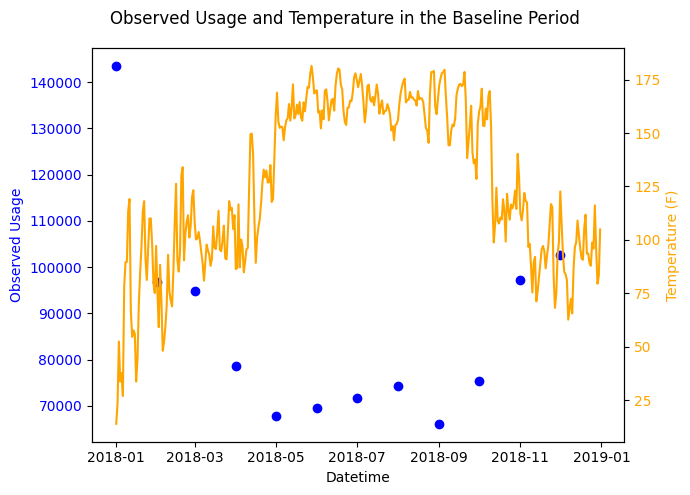

In [29]:
fig, ax1 = plt.subplots(figsize=(7, 5))

color = 'blue'
ax1.set_xlabel('Datetime')
ax1.set_ylabel('Observed Usage', color=color)
ax1.plot(df_baseline_n.index, df_baseline_n['observed'], label='Observed Usage', color=color, marker='o', linestyle='-')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'orange'
ax2.set_ylabel('Temperature (F)', color=color)
ax2.plot(df_baseline_n.index, df_baseline_n['temperature'], label='Temperature (F)', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.suptitle('Observed Usage and Temperature in the Baseline Period')
fig.tight_layout()
plt.show()

In [30]:
print(baseline_data.df)

                           season weekday_weekend  temperature     observed
datetime                                                                   
2018-01-01 00:00:00-06:00  winter         weekday    13.918750  4629.918065
2018-01-02 00:00:00-06:00  winter         weekday    23.518750  4629.918065
2018-01-03 00:00:00-06:00  winter         weekday    52.433750  4629.918065
2018-01-04 00:00:00-06:00  winter         weekday    33.749583  4629.918065
2018-01-05 00:00:00-06:00  winter         weekday    37.665833  4629.918065
...                           ...             ...          ...          ...
2018-12-27 00:00:00-06:00  winter         weekday   116.167917  3311.234194
2018-12-28 00:00:00-06:00  winter         weekday    95.581667  3311.234194
2018-12-29 00:00:00-06:00  winter         weekend    79.494583  3311.234194
2018-12-30 00:00:00-06:00  winter         weekend    83.234583  3311.234194
2018-12-31 00:00:00-06:00  winter         weekday   104.880435  3311.234194

[365 rows x

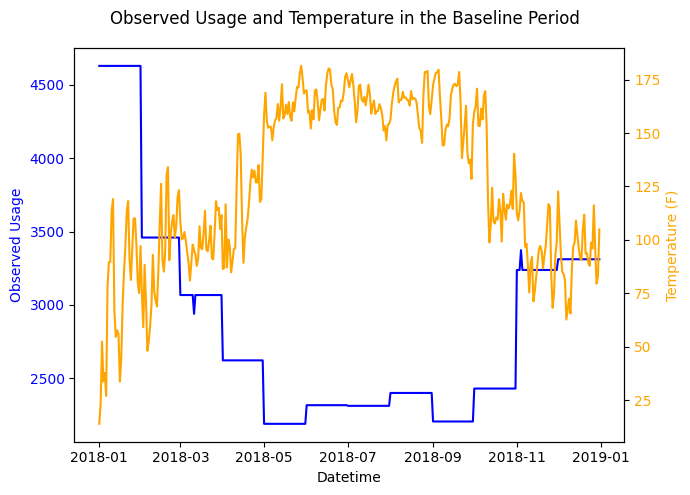

In [31]:
fig, ax1 = plt.subplots(figsize=(7, 5))

color = 'blue'
ax1.set_xlabel('Datetime')
ax1.set_ylabel('Observed Usage', color=color)
ax1.plot(baseline_data.df.index, baseline_data.df['observed'], label='Observed Usage', color=color, linestyle='-')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'orange'
ax2.set_ylabel('Temperature (F)', color=color)
ax2.plot(baseline_data.df.index, baseline_data.df['temperature'], label='Temperature (F)', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.suptitle('Observed Usage and Temperature in the Baseline Period')
fig.tight_layout()
plt.show()

In [32]:
# baseline_data = em.BillingBaselineData.from_series(df_baseline_n['observed'], df_baseline_n['temperature'], is_electricity_data=True)

In [33]:
print(f"Disqualifications: {baseline_data.disqualification}")
print(f"Warnings:          {baseline_data.warnings}")

Disqualifications: []
Warnings:          [EEMeterWarning(qualified_name=eemeter.sufficiency_criteria.unable_to_confirm_daily_temperature_sufficiency)]


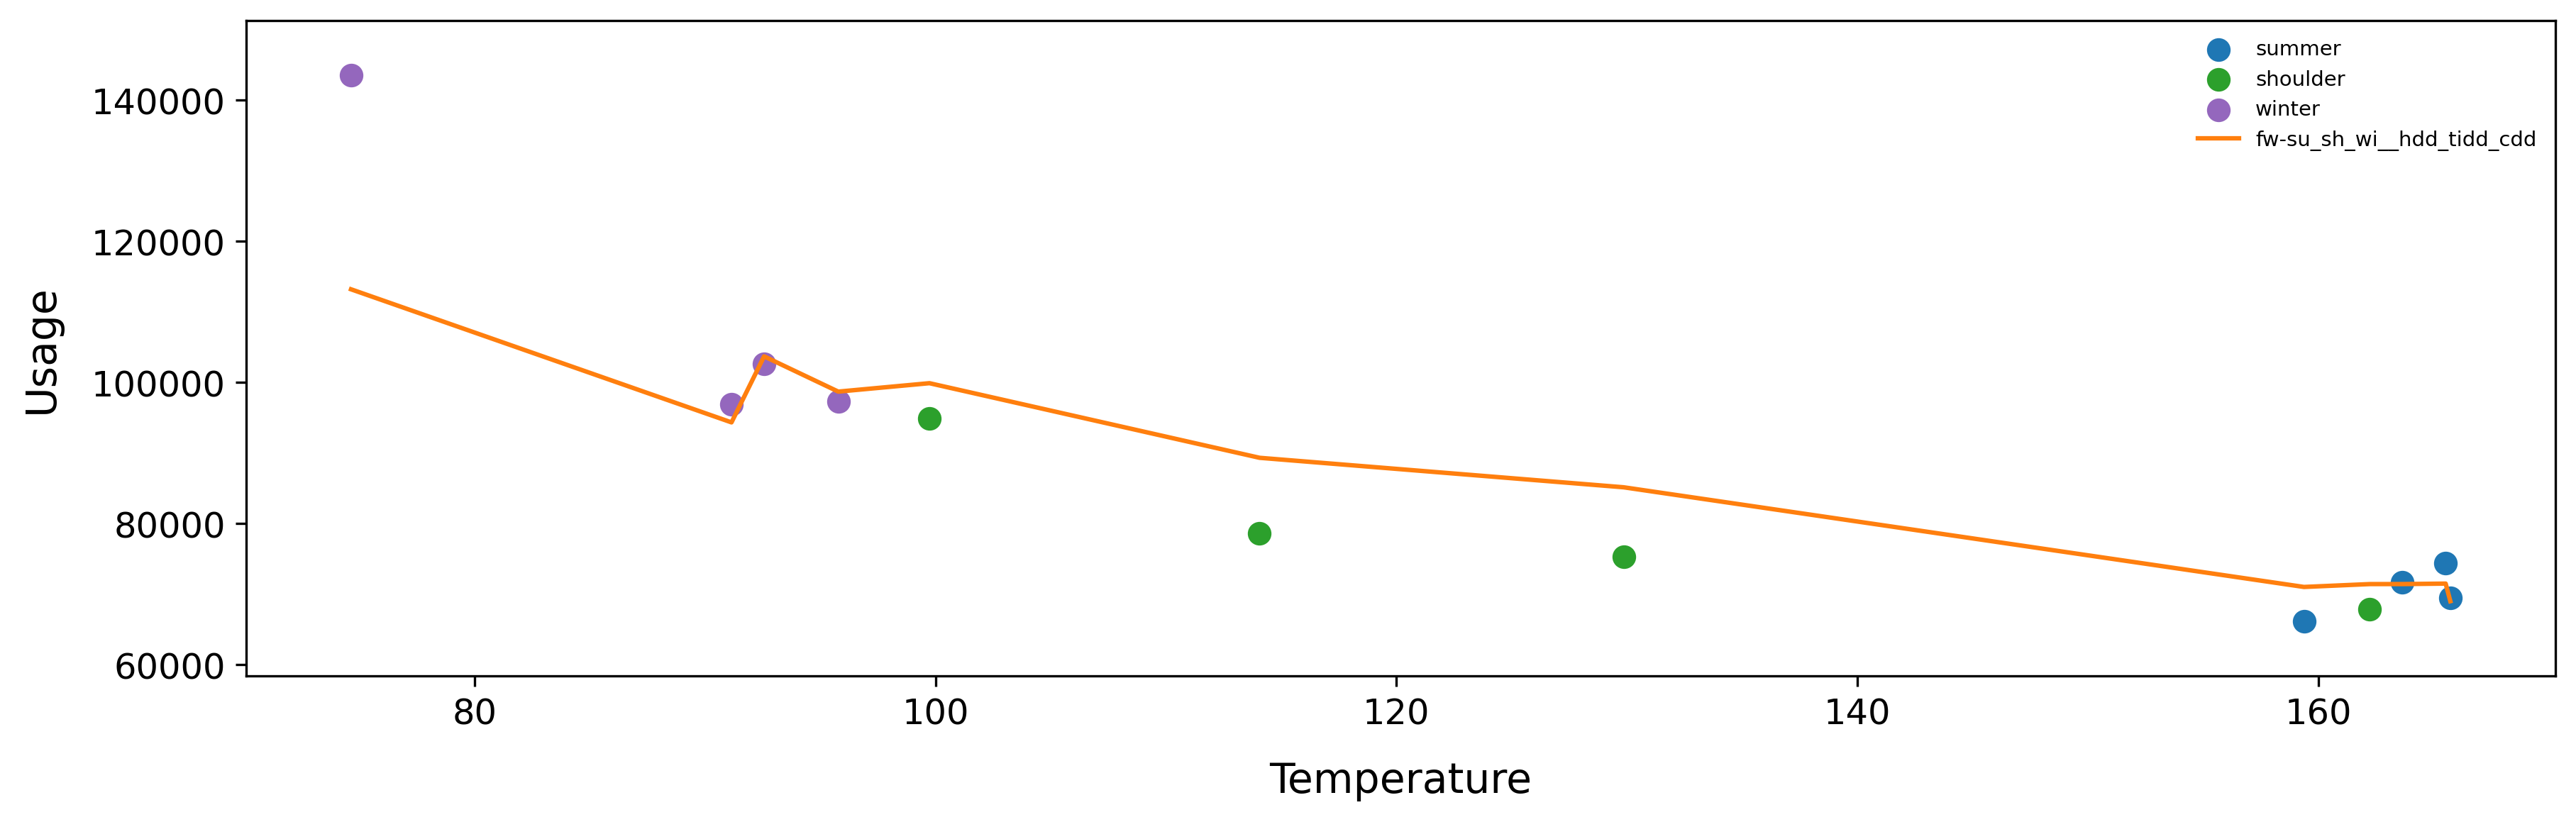

In [34]:
billing_model.plot(baseline_data, aggregation="monthly")

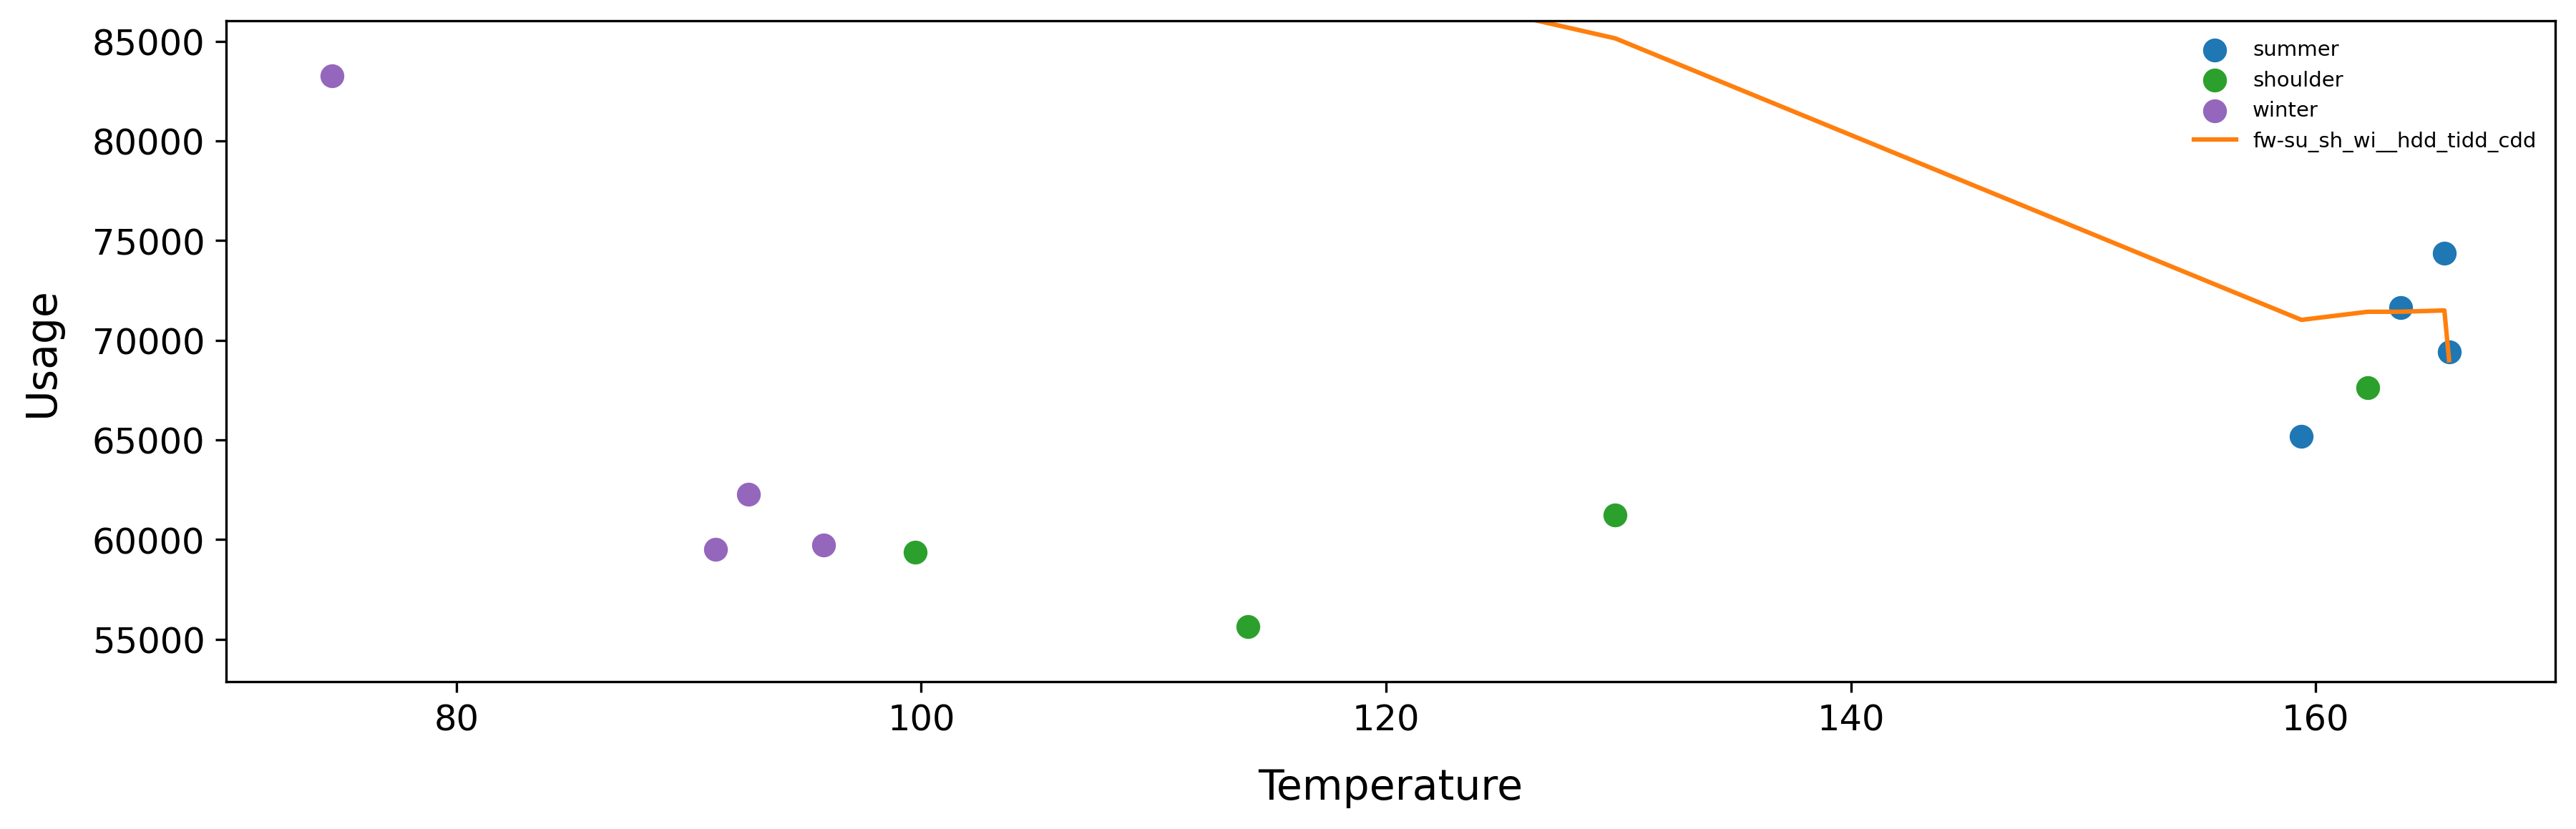

In [35]:
billing_model.plot(reporting_data, aggregation="monthly")

The billing model prediction function does have additional functionality built into it where it can aggregate from averaged daily data to `monthly` or `bimonthly`

In [36]:
df_results = billing_model.predict(reporting_data, aggregation="monthly")
print(df_results.head())

                             season  temperature  observed      predicted  \
datetime                                                                    
2019-01-01 00:00:00-06:00    winter    74.632849  83259.67  113202.180426   
2019-02-01 00:00:00-06:00    winter    91.144970  59501.01   94341.675948   
2019-03-01 00:00:00-06:00  shoulder    99.737932  59374.72   99894.899821   
2019-04-01 00:00:00-05:00  shoulder   114.063389  55628.45   89324.034252   
2019-05-01 00:00:00-05:00  shoulder   162.241210  67624.01   71428.393709   

                           predicted_unc  heating_load  cooling_load  \
datetime                                                               
2019-01-01 00:00:00-06:00    4873.237875  42140.513295       0.00000   
2019-02-01 00:00:00-06:00    4631.437200  30156.944345       0.00000   
2019-03-01 00:00:00-06:00    4873.237875  28833.232690       0.00000   
2019-04-01 00:00:00-05:00    4793.992953  20554.678964       0.00000   
2019-05-01 00:00:00-05:00   

In [37]:
df_results['savings'] = df_results['predicted'] - df_results['observed']
print(f"Predicted Usage (kWh):  {round(df_results['predicted'].sum(), 2)}")
print(f"Observed Usage (kWh):   {round(df_results['observed'].sum(), 2)}")
print(f"Savings (kWh):          {round(df_results['savings'].sum(), 2)}")

Predicted Usage (kWh):  1038682.55
Observed Usage (kWh):   789232.52
Savings (kWh):          249450.03


In [38]:
saved_model = billing_model.to_json()
print(saved_model)

{"submodels": {"fw-su_sh_wi": {"coefficients": {"model_type": "hdd_tidd_cdd", "intercept": 2292.311842935775, "hdd_bp": 154.13377004957601, "hdd_beta": 17.098813278656905, "hdd_k": null, "cdd_bp": 155.63428907217013, "cdd_beta": 0.61948431794673, "cdd_k": null}, "temperature_constraints": {"T_min": 13.918750000000001, "T_max": 181.40791666666667, "T_min_seg": 54.58083333333334, "T_max_seg": 178.07916666666665}, "f_unc": 875.2593603788916}}, "info": {"metrics": {"num_model_params": 5, "wrmse": 418.5867432065518, "n": 365, "n_prime": 26.801763972270948, "ddof": 360, "ddof_autocorr": 21.801763972270948, "observed": {"sum": 1038720.36, "mean": 2845.809205479452, "variance": 488230.00930036814, "std": 698.7345771466931, "cvstd": 0.24553106926540172, "sum_squared": 3134203915.8015647, "median": 2429.3206451612905, "MAD_scaled": 333.1080693654833, "iqr": 926.6736204196686, "skew": 1.2630607155437013, "kurtosis": 0.9174909750646942}, "predicted": {"sum": 1038664.324375968, "mean": 2845.6556832

In [39]:
loaded_model = em.BillingModel.from_json(saved_model)

In [40]:
# set rows 1:38 of observed to nan
df_baseline_n_dq = df_baseline_n.copy()
df_baseline_n_dq.loc[df_baseline_n_dq.index[1:38], "observed"] = np.nan

baseline_data_DQ = em.BillingBaselineData(df_baseline_n_dq, is_electricity_data=True)
print(f"Disqualifications: {baseline_data_DQ.disqualification}")

['2018-01-01T00:00:00-06:00']
{'n_days_total': 306}


Disqualifications: [EEMeterWarning(qualified_name=eemeter.sufficiency_criteria.offcycle_reads_in_billing_monthly_data), EEMeterWarning(qualified_name=eemeter.sufficiency_criteria.incorrect_number_of_total_days)]


In [41]:
try:
    billing_model = em.BillingModel().fit(baseline_data_DQ)
except Exception as e:
    print(f"Exception: {e}")

['2018-01-01T00:00:00-06:00']
{'n_days_total': 306}


Exception: Can't fit model on disqualified baseline data


In [42]:
billing_model = em.BillingModel().fit(baseline_data_DQ, ignore_disqualification=True)

['2018-01-01T00:00:00-06:00']
{'n_days_total': 306}


## Full Example

Disqualifications: []
Warnings:          [EEMeterWarning(qualified_name=eemeter.sufficiency_criteria.unable_to_confirm_daily_temperature_sufficiency)]


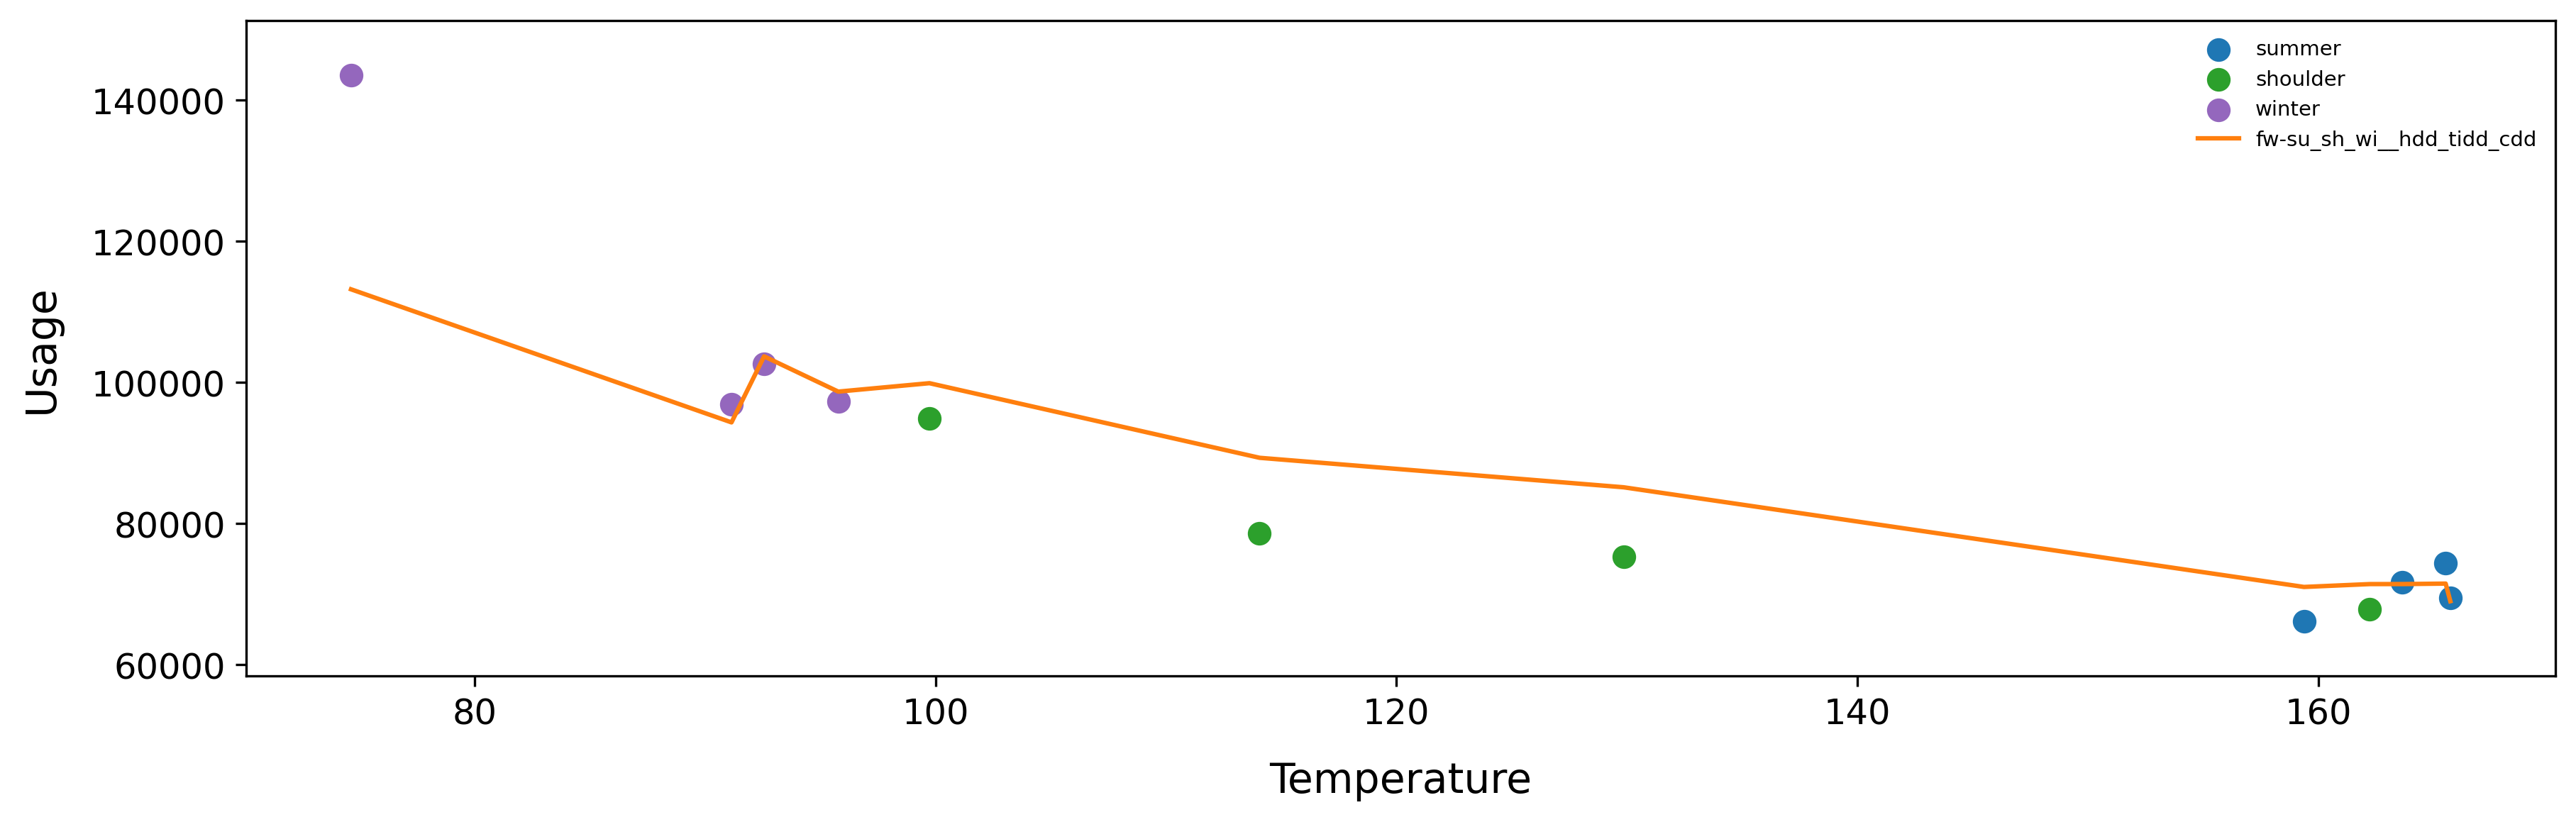

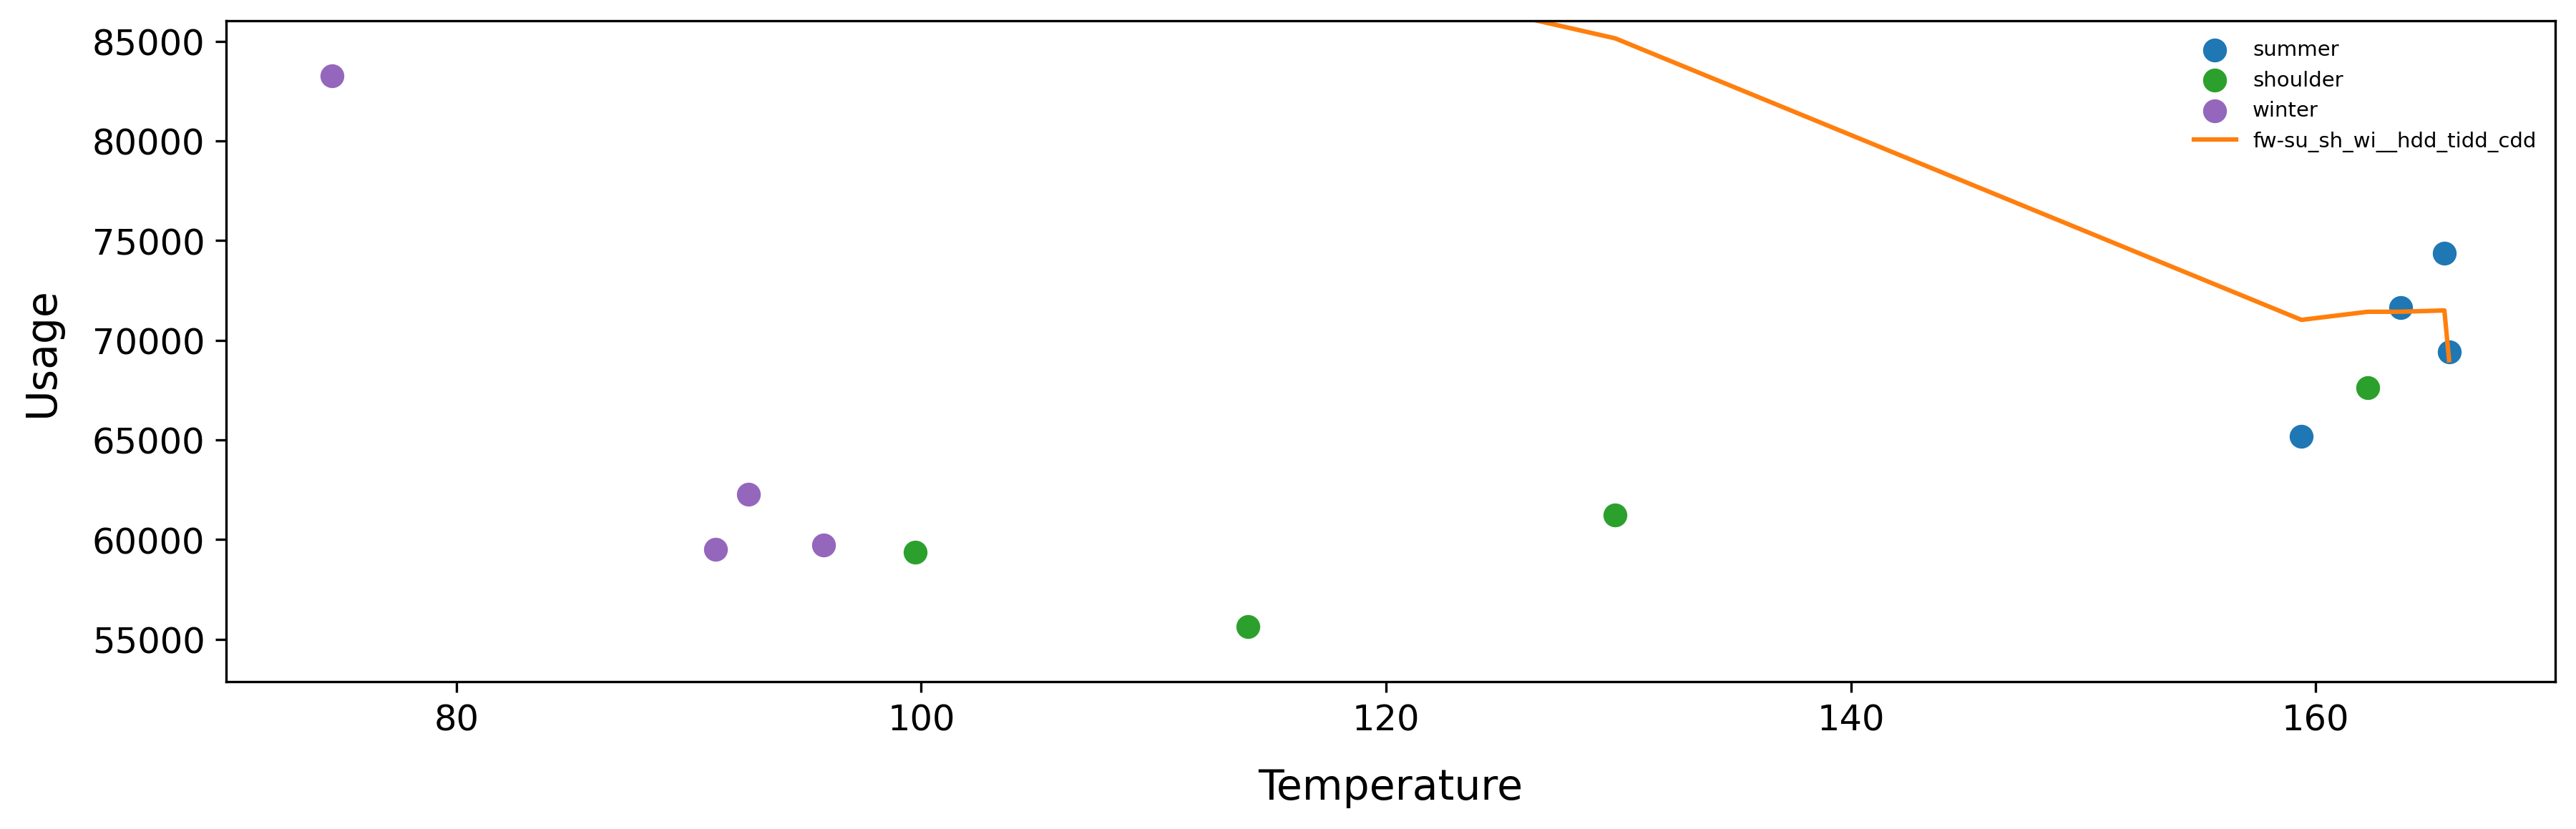

Predicted Usage (kWh):  1038682.55
Observed Usage (kWh):   789232.52
Savings (kWh):          249450.03


In [43]:
import numpy as np
import matplotlib.pyplot as plt

import opendsm as odsm
from opendsm import eemeter as em

df_baseline, df_reporting =  odsm.test_data.load_test_data("monthly_treatment_data")

n = 15

id = df_baseline.index.get_level_values(0).unique()[n]

df_baseline_n = df_baseline.loc[id]
df_reporting_n = df_reporting.loc[id]

baseline_data = em.BillingBaselineData(df_baseline_n, is_electricity_data=True)
reporting_data = em.BillingReportingData(df_reporting_n, is_electricity_data=True)

print(f"Disqualifications: {baseline_data.disqualification}")
print(f"Warnings:          {baseline_data.warnings}")

billing_model = em.BillingModel()
billing_model.fit(baseline_data)

# Save model to json
saved_model = billing_model.to_json()
loaded_model = em.BillingModel.from_json(saved_model)

# Model results
billing_model.plot(baseline_data, aggregation="monthly")
billing_model.plot(reporting_data, aggregation="monthly")

df_results = billing_model.predict(reporting_data, aggregation="monthly")
df_results['savings'] = df_results['predicted'] - df_results['observed']
print(f"Predicted Usage (kWh):  {round(df_results['predicted'].sum(), 2)}")
print(f"Observed Usage (kWh):   {round(df_results['observed'].sum(), 2)}")
print(f"Savings (kWh):          {round(df_results['savings'].sum(), 2)}")

Similarly, the plot function also has the ability to aggregate to `monthly` or `bimonthly`. 

This model is still at its core, a modified daily model though. This is why the model prediction is not straight for either of the aggregations.

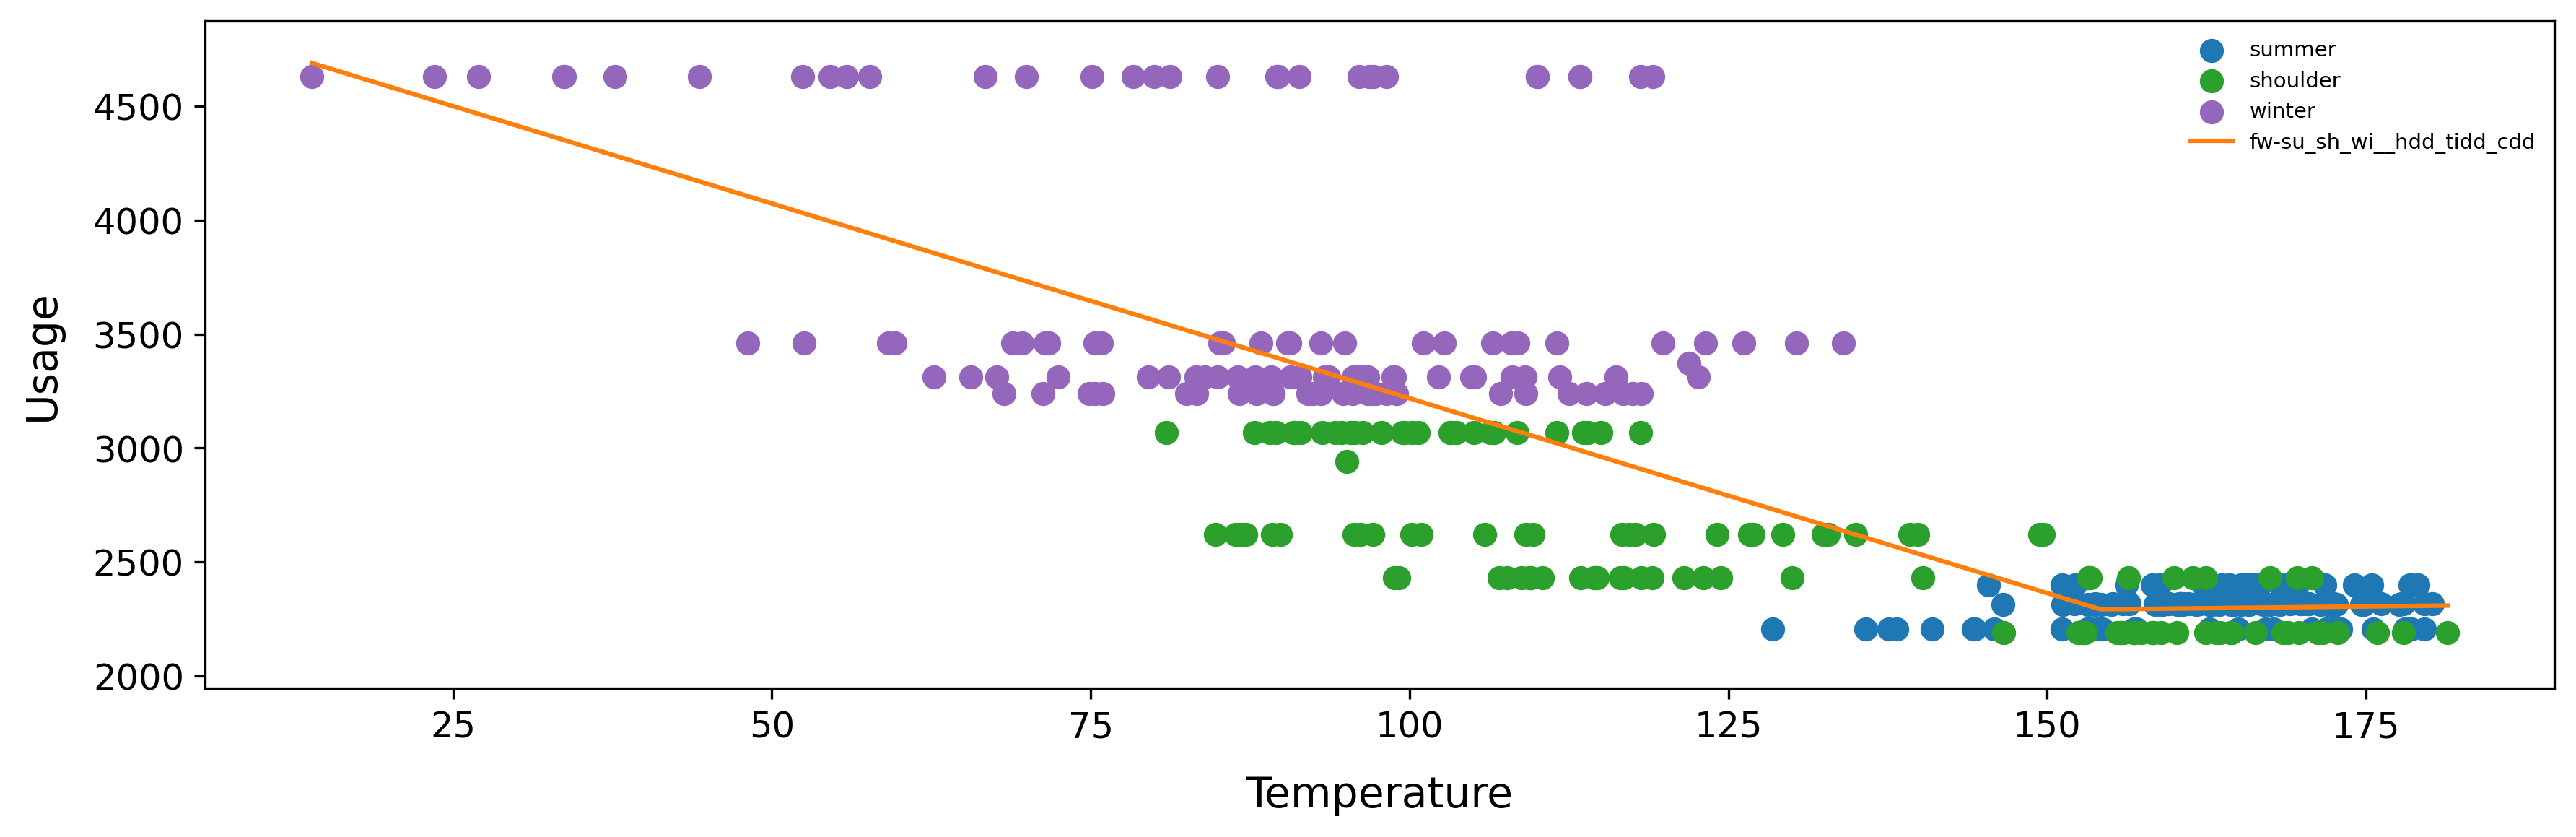

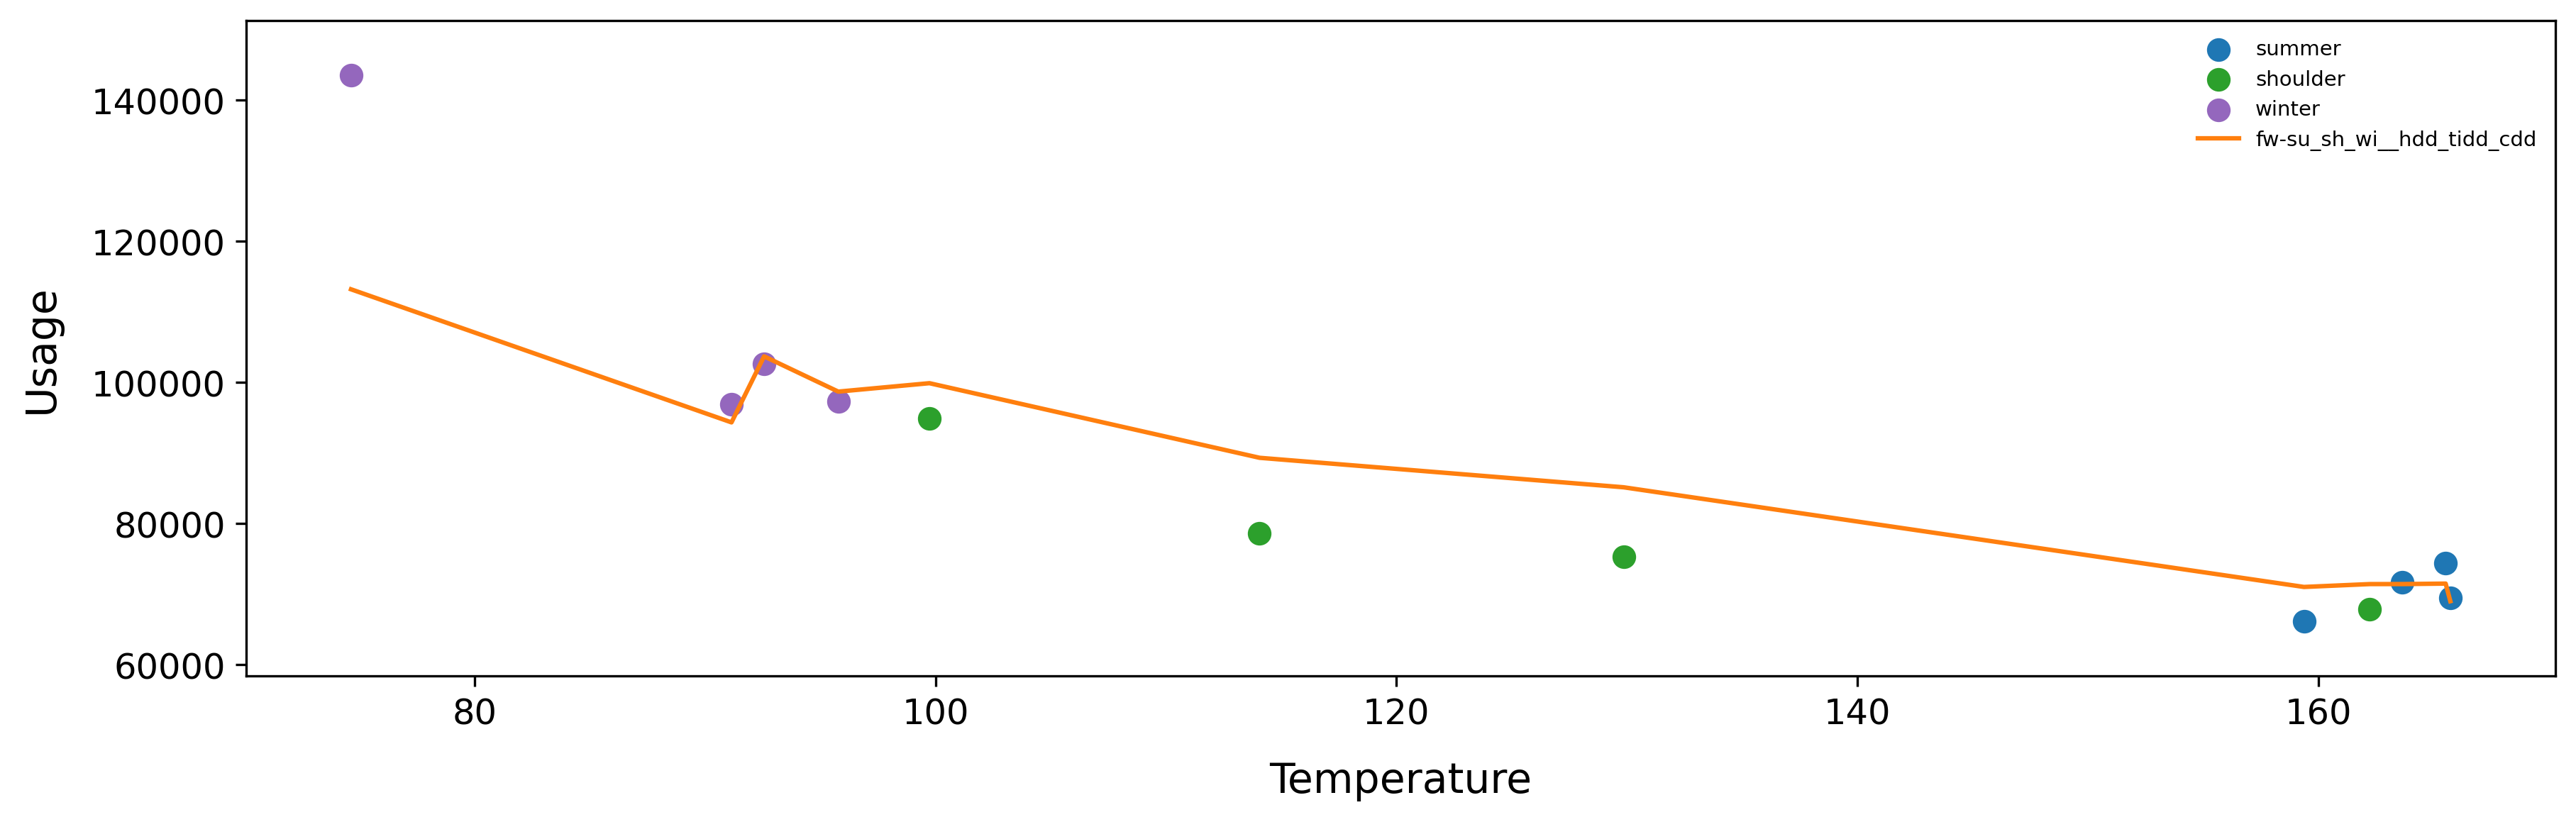

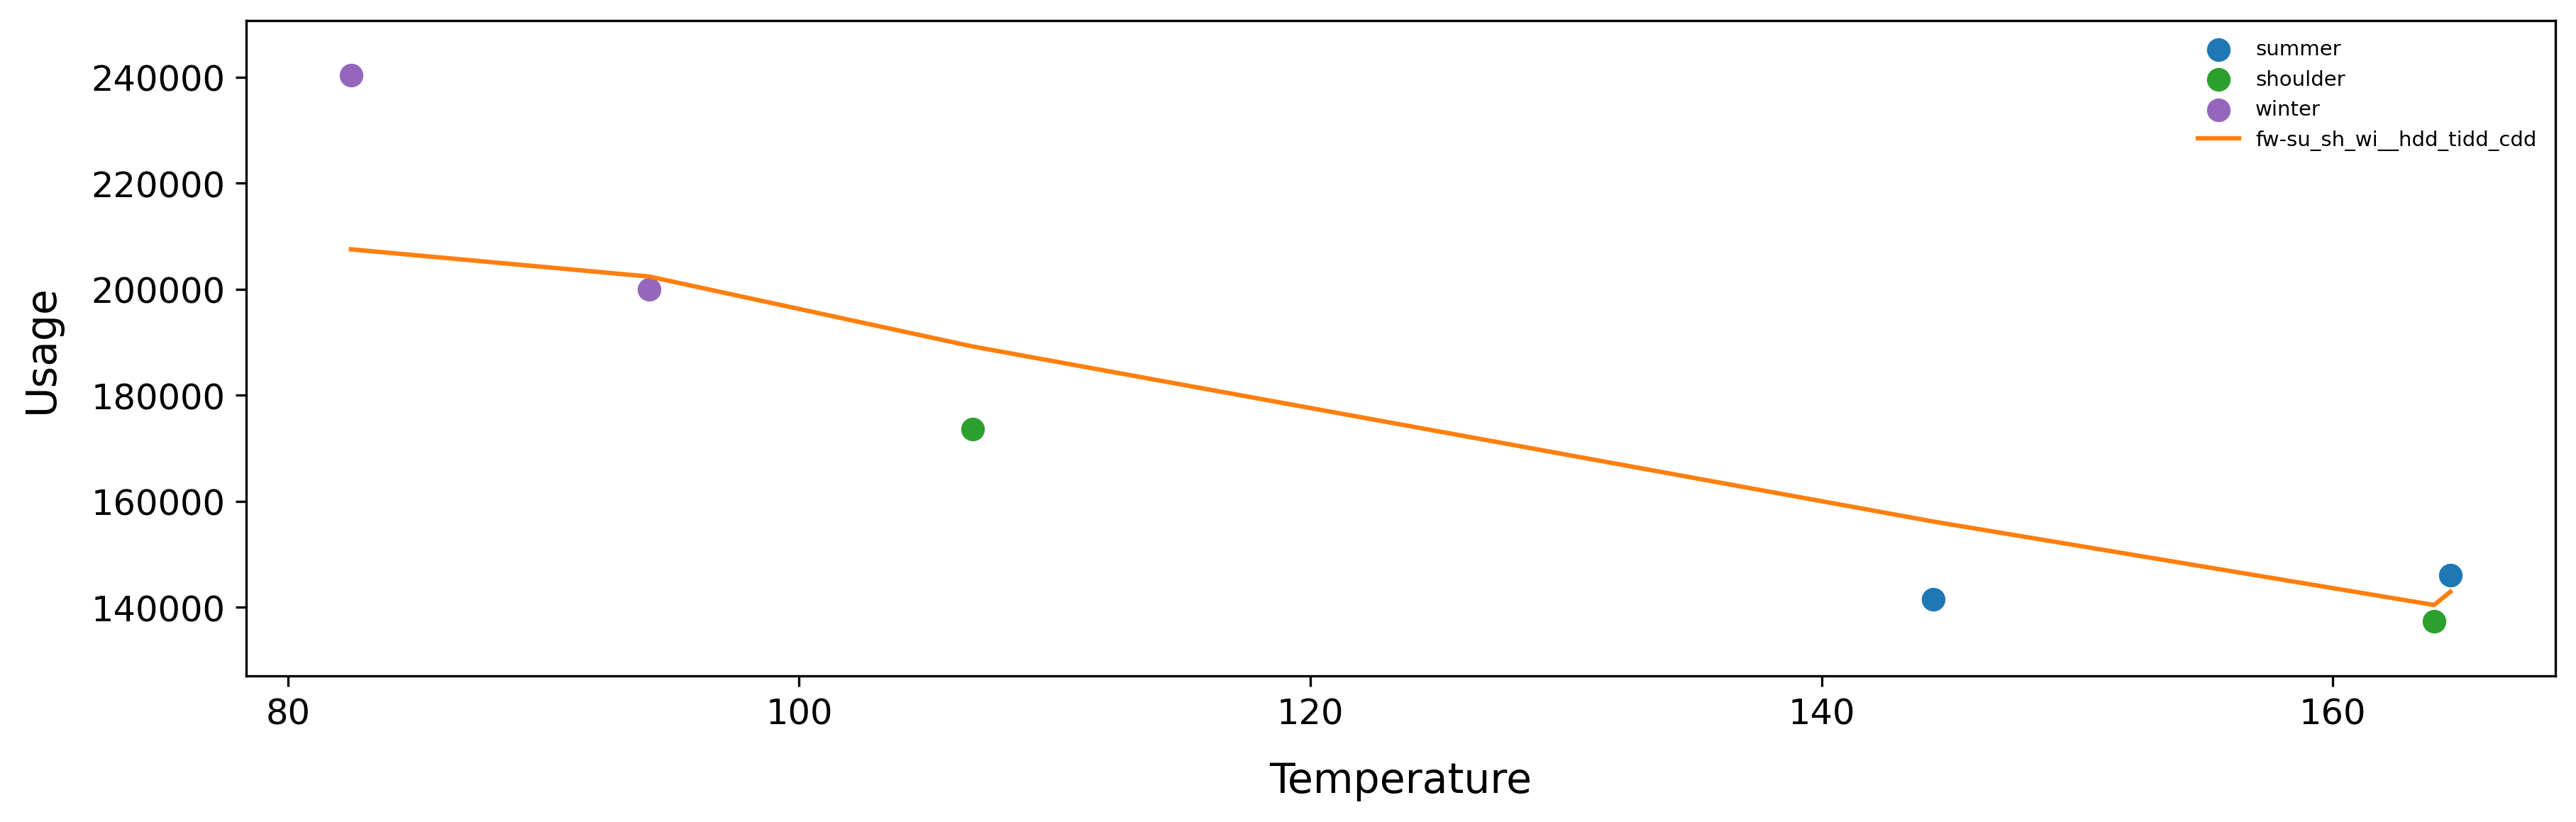

In [44]:
billing_model.plot(baseline_data)

billing_model.plot(baseline_data, aggregation="monthly")

billing_model.plot(baseline_data, aggregation="bimonthly")